#Image classification with RNN

Let's try to build an image classifier using the MNIST dataset. The MNIST dataset consists of images that contain hand-written numbers from 1–10. Essentially, we want to build a classifier to predict the numbers displayed by a set of images.

# Initialization: Downloads, Imports, and Parameters

This section of code is where you set the size of the batch (dataset), download and load the training and testing dataset, and import the image.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

In [0]:
import torchvision
import torchvision.transforms as transforms

In [3]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# Data Loader for easy mini-batch return in training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
# Data Loader for easy mini-batch return in training
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

0it [00:00, ?it/s]

9920512it [00:01, 8106259.97it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129543.17it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2135243.00it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 50074.60it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


We can see how many examples are in each split by checking their length.

In [4]:
print(f'Number of training examples: {len(trainloader)}')
print(f'Number of testing examples: {len(testloader)}')

Number of training examples: 938
Number of testing examples: 157


We can also check a batch of examples.

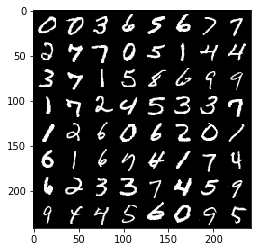

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Build the Model

The method containing the actual code of the neural network codes the neurons, inputs, outputs.  The output is the model probabilities, and sets initial weights for the nodes of the neural network.

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

This step is just the code to test a sample of the data in the model before actually training it. It allows you to track your progress, and make sure that the model is functioning the way you want it to. That way, you will be able to easily correct and locate any errors that you may find.

In [0]:
# parameters 
N_STEPS = 28      # rnn time step / image height
N_INPUTS = 28     # rnn input size / image width
N_NEURONS = 150   # number of neurons in each RNN's cell
N_OUTPUTS = 10    # classes
N_EPHOCS = 10     

The figure below shows figure of the RNN-based classification model we are building

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 4.5369e-03,  1.4249e-01,  2.8238e-02, -1.2456e-03, -1.6528e-01,
          1.7478e-02,  1.4184e-02,  6.4064e-02,  1.3588e-01, -2.9654e-03],
        [-1.2982e-02,  9.8701e-02, -4.0354e-02, -2.1512e-02, -8.6183e-02,
          2.5070e-02, -1.2245e-02,  3.0660e-02,  1.1530e-01,  5.5148e-03],
        [ 1.4250e-03,  7.2800e-02, -1.2018e-02, -1.2973e-03, -9.3598e-02,
          4.1919e-02, -1.8920e-02,  2.6723e-02,  1.0609e-01,  1.4934e-02],
        [-8.3291e-03,  7.0022e-02,  3.2883e-03, -2.8190e-02, -1.1231e-01,
          2.9412e-02,  2.3118e-02,  7.0230e-02,  1.2062e-01,  1.8004e-02],
        [-1.0650e-02,  7.9310e-02,  2.8389e-03,  7.0175e-03, -1.0133e-01,
          2.6079e-02,  7.7570e-03,  5.6726e-02,  1.0017e-01,  1.5975e-02],
        [ 2.0929e-05,  7.9687e-02, -2.5980e-02, -9.9445e-03, -8.4492e-02,
          4.2299e-02, -1.5017e-02,  2.7694e-02,  1.1912e-01,  1.4543e-02],
        [ 4.7300e-03,  6.6010e-02, -1.7726e-02,  3.6650e-03, -9.4733e-02,
          4.5732e-02, -1.5930e-0

# Training and Testing Model

The model updates with every iteration, adjusting weights and biases in order to minimize the loss function and improve the accuracy percentage. The algorithm has an optimization function (optim.Adam) that ensures the system improves the accuracy per epoch, as opposed to randomly adjusting weights and biases so the accuracy fluctuates.

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

This is the code that puts together the model and its testing and training. The output gives the loss function, and the percentage accuracy with every epoch. When it is ran, we see how the neural network gradually decreases the loss function, and has the accuracy approach 100% due to the optimization function and the adjustment of weights and biases.

In [10]:
n = 0
lst_loss = []
lst_acc = []
# loop over the dataset multiple times
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        n += 1
         # zero the parameter gradients
        optimizer.zero_grad()
        #print(i+1)
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    lst_loss.append(train_running_loss / i)
    lst_acc.append(train_acc / i)
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc / i))

Epoch:  0 | Loss: 0.7626 | Train Accuracy: 74.25
Epoch:  1 | Loss: 0.3219 | Train Accuracy: 90.61
Epoch:  2 | Loss: 0.2374 | Train Accuracy: 93.10
Epoch:  3 | Loss: 0.2012 | Train Accuracy: 94.22
Epoch:  4 | Loss: 0.1704 | Train Accuracy: 95.20
Epoch:  5 | Loss: 0.1579 | Train Accuracy: 95.61
Epoch:  6 | Loss: 0.1496 | Train Accuracy: 95.81
Epoch:  7 | Loss: 0.1339 | Train Accuracy: 96.31
Epoch:  8 | Loss: 0.1283 | Train Accuracy: 96.39
Epoch:  9 | Loss: 0.1253 | Train Accuracy: 96.50


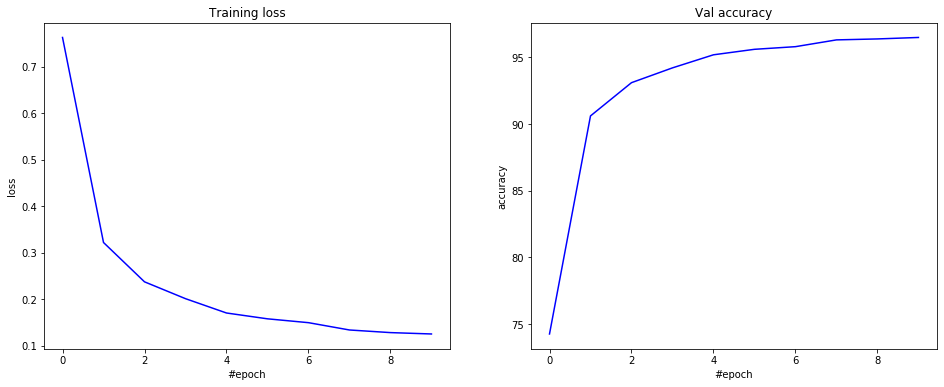

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)    
plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(lst_loss, 'b')

plt.subplot(1, 2, 2)
plt.title("Val accuracy")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(lst_acc, 'b')
plt.show()

The 'Test Accuracy' portion  gives a final accuracy percentage after 10 epochs. And there you have it: image classification with recurrent neural networks!

In [12]:
lst_test_acc = []
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)    
print('Test Accuracy: %.2f'%(test_acc / i))

Test Accuracy: 97.39


Notice that we are not using GPU in this tutorial since the models we are building are relatively simple.

More materials: 
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
* https://www.youtube.com/watch?v=6niqTuYFZLQ

Examples:
* https://www.dezyre.com/recipes/run-basic-rnn-model-using-pytorch
* https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79
* https://medium.com/@nathaliejeans7/how-i-classified-images-with-recurrent-neural-networks-28eb4b57fc79